# Imports

In [ ]:
from qiskit import *
from qiskit.circuit import Parameter, ParameterExpression, Gate, Qubit
from qiskit.circuit.library import XGate, YGate, ZGate, IGate, CPhaseGate
from qiskit.quantum_info import Operator, Statevector, random_clifford, Clifford, Pauli, DensityMatrix
from qiskit.quantum_info import SparsePauliOp, PauliList, random_statevector, StabilizerTable
from qiskit.quantum_info import pauli_basis, StabilizerState, DensityMatrix, random_density_matrix, random_unitary

import numpy as np
from functools import reduce
from itertools import product
# from cpflow.trigonometric_utils import min_angle

# from cpflow import *
# from cpflow.topology import *
import matplotlib.pyplot as plt
from mynimize import *
import jax.numpy as jnp
from collections import namedtuple

from wave_expansion import *
from experiments_utils import *
from tests.test_wave_expansion import *
from jax_utils import jax_tensor, jax_loss, jax_fourier_mode

from jax import random, grad
import cProfile
from functools import partial
from random import sample

# %%prun -s cumulative -l 20

# Are there traps at order 2?

A trapping loss landscape with not too demanding resources.

CPU times: user 45.5 s, sys: 219 ms, total: 45.8 s
Wall time: 45.9 s


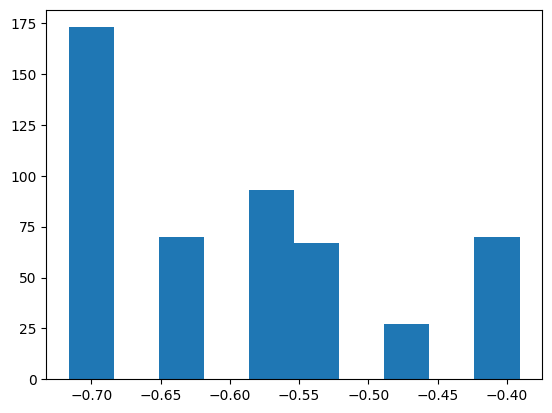

In [2]:
%%time

num_qubits = 5
depth = 0
num_pauli_terms = 40

e = Experiment(num_qubits, depth, num_pauli_terms)
opt_options = OptOptions(learning_rate=0.01, num_iterations=5000)
res = e.run(num_samples=500, opt_options=opt_options)

Lowest Fourier modes of the loss function.

In [28]:
%%time

vqa = e.vqa
vqa.fourier_expansion(up_to_order=3)
f0 = jax_fourier_mode(vqa.fourier_modes[0])
f1 = jax_fourier_mode(vqa.fourier_modes[1])
f2 = jax_fourier_mode(vqa.fourier_modes[2])
f3 = jax_fourier_mode(vqa.fourier_modes[3])

proxy_loss = lambda x: jnp.real(f0(x)+f1(x)+f2(x)+f3(x))

CPU times: user 2min 36s, sys: 167 ms, total: 2min 36s
Wall time: 2min 37s


Quadratic truncation has no traps.

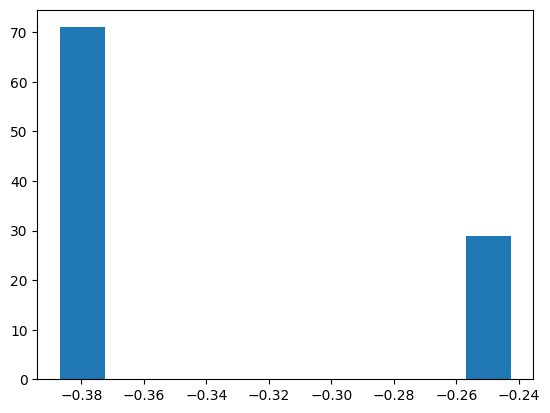

In [29]:
num_samples = 100
angles_batch = Experiment.random_parameter_batch(num_samples, vqa.circuit.num_parameters)
proxy_res = mynimize(proxy_loss, angles_batch, opt_options)
plt.hist(np.array(proxy_res.all_best_losses));

Is the minimum of quadratic truncation useful for initialization?

In [25]:
num_samples=500

best_quadratic_params = proxy_res.best_result.best_params()
full_loss = e.loss_func()
initial_params_batch = best_quadratic_params+0.3*e.random_parameter_batch(num_samples, vqa.circuit.num_parameters)

res_quadratic_init = mynimize(full_loss, initial_params_batch, opt_options)

In [30]:
num_samples=500

best_qubic_params = proxy_res.best_result.best_params()
full_loss = e.loss_func()
initial_params_batch = best_qubic_params+0.3*e.random_parameter_batch(num_samples, vqa.circuit.num_parameters)

res_qubic_init = mynimize(full_loss, initial_params_batch, opt_options)

In [35]:
res.success_ratio()

DeviceArray(0., dtype=float32)

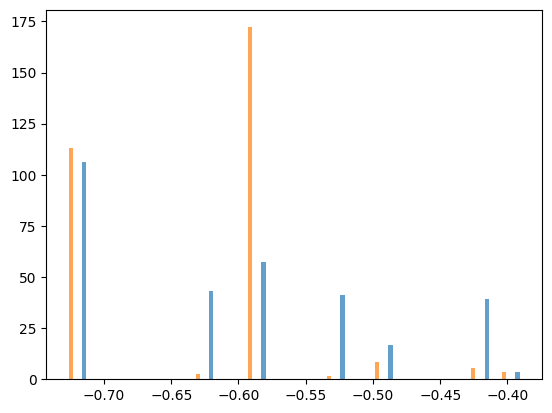

In [38]:
plt.hist(res.all_best_losses, alpha=0.7, bins=100, density=True);
# plt.hist(res_quadratic_init.all_best_losses, alpha=0.7, bins=100);
plt.hist(res_qubic_init.all_best_losses-0.01, alpha=0.7, bins=100, density=True);

In [ ]:
full_loss(best)

# Using heuristic average for initialization

In [9]:
key = random.PRNGKey(42)

num_qubits = 3
num_parameters = 5

qc = random_clifford_phi(num_qubits, num_parameters)
state = random_statevector(2**num_qubits, seed=0)
loss = Loss.from_state(state)
vqa = CliffordPhiVQA(qc, loss)

loss_from_fourier = vqa.fourier_expansion(jax=True)
def loss(X):
    return jnp.real(loss_from_fourier(X.x))

X = namedtuple('X', ['x'])

num_samples = 1000
key, subkey = random.split(key)
x0_uniform_batch = 2*jnp.pi*random.uniform(subkey, (num_samples, vqa.circuit.num_parameters))
X0_uniform_batch = [X(x) for x in x0_uniform_batch]

opt_options=OptOptions(num_iterations=2000, learning_rate=0.01)
res_uniform = mynimize(loss, X0_uniform_batch, opt_options=opt_options)

2022-12-01 18:29:23.719799: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:55] 
********************************
Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
Compiling module jit_single_minimize.53
********************************


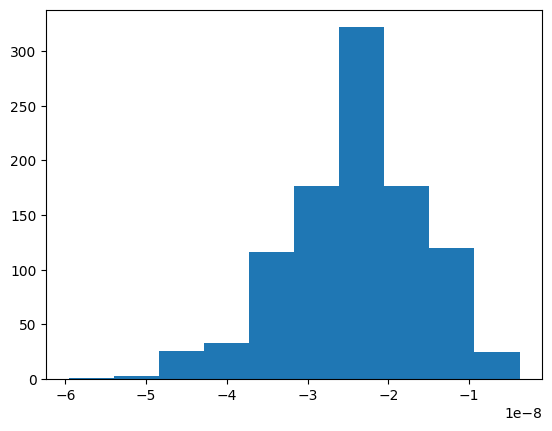

In [10]:
plt.hist(res_uniform.all_best_losses);

In [23]:

num_qubits = 2
depth = 2

anz = Ansatz(num_qubits, 'cz', fill_layers(chain_layer(num_qubits), depth), rotation_gates='xz')
state = random_statevector(2**num_qubits, seed=0)

qc = CliffordPhi.from_quantum_circuit(anz.circuit())
vqa = CliffordPhiVQA(qc, Loss.from_state(state))

permutation = [int(p.name[3:-1]) for p in vqa.circuit.parameters]
inverse_permutation = np.argsort(permutation)

X = namedtuple('X', ['x'])
def loss(x):
    x = x.x
    x_p = [x[p] for p in inverse_permutation]
    u = anz.unitary(jnp.array(x_p))
    s = u@Statevector.from_label('0'*num_qubits).data
    
    return np.abs((s.conj() * state.reverse_qargs().data).sum())**2


num_samples = 10
key, subkey = random.split(key)
x0_uniform_batch = 2*jnp.pi*random.uniform(subkey, (num_samples, anz.num_angles))
X0_uniform_batch = [X(x) for x in x0_uniform_batch]


loss(X0_uniform_batch[1])

0.37283417321009793

In [24]:
vqa.evaluate_loss_at(np.array(x0_uniform_batch[1]))

(0.37283429717282396+0j)

In [ ]:

    

num_samples = 1000
key, subkey = random.split(key)
opt_options=OptOptions(num_iterations=2000, learning_rate=0.01)


x0_uniform_batch = 2*jnp.pi*random.uniform(subkey, (num_samples, anz.num_angles))
X0_uniform_batch = [X(x) for x in x0_uniform_batch]

res_uniform = mynimize(loss, X0_uniform_batch, opt_options=opt_options)

key, subkey = random.split(key)
hmin, x0 = pqc.heuristic_min(H)
x0_heuristic_batch = jnp.array(x0)+0.1*random.normal(subkey, (num_samples, anz.num_angles))
X0_heuristic_batch = [X(x) for x in x0_heuristic_batch]

res_heuristic = mynimize(loss, X0_heuristic_batch, opt_options=opt_options)

print(res_uniform)
print(res_heuristic) 

plt.hist(np.array(res_uniform.all_best_losses), density=True, alpha=0.8);
plt.hist(np.array(res_heuristic.all_best_losses), density=True, alpha=0.8);

allclose: True
OptMultiResult(best_loss -2.8169705867767334, success_ratio 0.0, num_samples 1000)
OptMultiResult(best_loss -2.816957950592041, success_ratio 0.0, num_samples 1000)


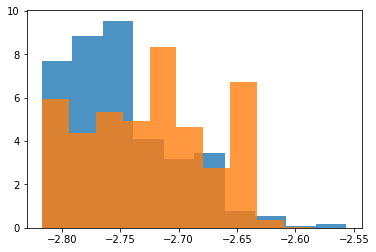

In [74]:
key = random.PRNGKey(42)

num_qubits = 5
depth = 10

anz = Ansatz(num_qubits, 'cz', fill_layers(chain_layer(num_qubits), depth), rotation_gates='xz')
pqc = PQC(anz.num_qubits)
pqc.data = anz.circuit().data
permutation = [int(p.name[3:-1]) for p in anz.circuit().parameters]
inverse_permutation = np.argsort(permutation)

### Test
x=np.random.rand(anz.num_angles)
x_p = [x[p] for p in inverse_permutation]
print('allclose:', jnp.allclose(anz.unitary(jnp.array(x_p)), Operator(pqc.bind_parameters(x).reverse_bits()).data))

key, subkey = random.split(key)
H = random.uniform(subkey, (2, 2**num_qubits, 2**num_qubits))
H = H[0]+1j*H[1]
H = (H+H.conj().T)/2


X = namedtuple('X', ['x'])
def loss(x):
    x = x.x
    x_p = [x[p] for p in inverse_permutation]
    u = anz.unitary(jnp.array(x_p))

    return PQC.average(H, u)

num_samples = 1000
key, subkey = random.split(key)
opt_options=OptOptions(num_iterations=2000, learning_rate=0.01)


x0_uniform_batch = 2*jnp.pi*random.uniform(subkey, (num_samples, anz.num_angles))
X0_uniform_batch = [X(x) for x in x0_uniform_batch]

res_uniform = mynimize(loss, X0_uniform_batch, opt_options=opt_options)

key, subkey = random.split(key)
hmin, x0 = pqc.heuristic_min(H)
x0_heuristic_batch = jnp.array(x0)+0.1*random.normal(subkey, (num_samples, anz.num_angles))
X0_heuristic_batch = [X(x) for x in x0_heuristic_batch]

res_heuristic = mynimize(loss, X0_heuristic_batch, opt_options=opt_options)

print(res_uniform)
print(res_heuristic) 

plt.hist(np.array(res_uniform.all_best_losses), density=True, alpha=0.8);
plt.hist(np.array(res_heuristic.all_best_losses), density=True, alpha=0.8);

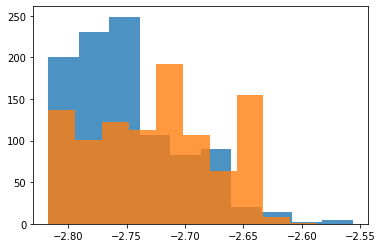

In [75]:
plt.hist(np.array(res_uniform.all_best_losses), alpha=0.8);
plt.hist(np.array(res_heuristic.all_best_losses), alpha=0.8);

In [76]:
print(res_uniform)
print(res_heuristic) 

OptMultiResult(best_loss -2.8169705867767334, success_ratio 0.0, num_samples 1000)
OptMultiResult(best_loss -2.816957950592041, success_ratio 0.0, num_samples 1000)


In [44]:
opt_options

OptOptions(learning_rate=0.01, num_iterations=2000, random_seed=0, regularization_func=None, keep_history=True)

In [41]:
OptOptions()

OptOptions(learning_rate=0.01, num_iterations=100, random_seed=0, regularization_func=None, keep_history=True)

In [40]:
pqc.draw()

┌───────────┐┌───────────┐┌───────────┐
q_0: ┤ Rz(a_{0}) ├┤ Rx(a_{1}) ├┤ Rz(a_{2}) ├
     ├───────────┤├───────────┤├───────────┤
q_1: ┤ Rz(a_{3}) ├┤ Rx(a_{4}) ├┤ Rz(a_{5}) ├
     └───────────┘└───────────┘└───────────┘

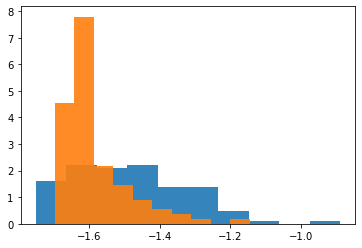

In [33]:
plt.hist(np.array(res_uniform.all_best_losses), density=True, alpha=0.9);
plt.hist(np.array(res_heuristic.all_best_losses), density=True, alpha=0.9);

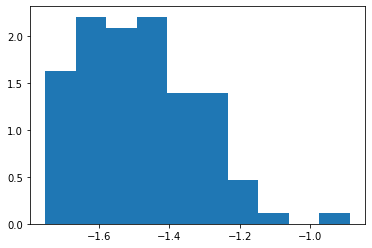

In [29]:
plt.hist(np.array(res_uniform.all_best_losses), density=True);
# plt.hist(np.array(res_heuristic.all_best_losses), density=True);

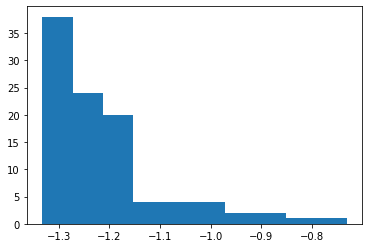

In [19]:
plt.hist(np.array(res_uniform.all_best_losses));

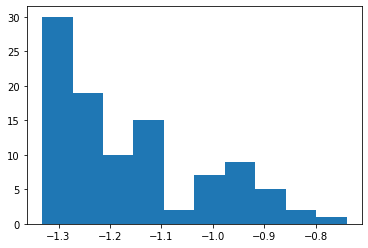

In [20]:
plt.hist(np.array(res_heuristic.all_best_losses));

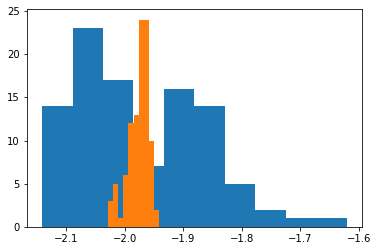

In [30]:
key = random.PRNGKey(0)

num_qubits = 4
depth = 12

anz = Ansatz(num_qubits, 'cz', fill_layers(chain_layer(num_qubits), depth), rotation_gates='xz')
pqc = PQC(anz.num_qubits)
pqc.data = anz.circuit().data
permutation = [int(p.name[3:-1]) for p in anz.circuit().parameters]
inverse_permutation = np.argsort(permutation)

### Test
#x=np.random.rand(anz.num_angles)
#x_p = [x[p] for p in inverse_permutation]
#jnp.allclose(anz.unitary(jnp.array(x_p)), Operator(pqc.bind_parameters(x).reverse_bits()).data)

key, subkey = random.split(key)
H = random.uniform(subkey, (2, 2**num_qubits, 2**num_qubits))
H = H[0]+1j*H[1]
H = (H+H.conj().T)/2


X = namedtuple('X', ['x'])
def loss(x):
    x = x.x
    x_p = [x[p] for p in inverse_permutation]
    u = anz.unitary(jnp.array(x_p))

    return PQC.average(H, u)

num_samples = 100
key, subkey = random.split(key)

x0_uniform_batch = 2*jnp.pi*random.uniform(subkey, (num_samples, anz.num_angles))
X0_uniform_batch = [X(x) for x in x0_uniform_batch]

res_uniform = mynimize(loss, X0_uniform_batch, opt_options=OptOptions())

key, subkey = random.split(key)
hmin, x0 = pqc.heuristic_min(H)
x0_heuristic_batch = jnp.array(x0)+0.01*random.normal(subkey, (num_samples, anz.num_angles))
X0_heuristic_batch = [X(x) for x in x0_heuristic_batch]

res_heuristic = mynimize(loss, X0_heuristic_batch, opt_options=OptOptions())

plt.hist(np.array(res_uniform.all_best_losses));
plt.hist(np.array(res_heuristic.all_best_losses));

In [ ]:
loss(X(x0))

In [ ]:
res_uniform

In [480]:
res_heuristic

OptMultiResult(best_loss -2.0294768810272217, success_ratio 0.0, num_samples 100)